In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
import statsmodels.stats.api as sapi
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('practice.csv')
df.head()

,date,users,orders
0,01/06/2018,2580,710
1,02/06/2018,2603,676
2,03/06/2018,2615,712
3,04/06/2018,2627,663
4,05/06/2018,2530,727


Посмотрим средную конверсию в заказ,  
стандартное отклонение конверсии (для определения mde),   
сколько у нас пользователей в день,  
и посчитаем сколько нужно людей для теста

In [6]:
conv = df.orders.sum() / df.users.sum()
conv

0.2676717104287198

In [21]:
conv_std = (df.orders / df.users).std()
conv_std

0.010224911360291656

In [15]:
users_avg = int(df.users.mean())
users_avg

2609

Так как у нас нет предполагаемого mde,  
то возьмем 1 стандартное отклонение конверсии за предыдущий период

In [120]:
mde = 0.01
conv = 0.3
p0, p1 = conv, conv + mde
alpha = 0.05
beta = 0.20
def get_size_two_ind(p0, pa, alpha, beta):
    za = st.norm.ppf(1- alpha / 2)
    zb = st.norm.ppf(1 - beta)
    var0 = p0 * (1 - p0)
    vara = pa * (1 - pa)
    n = (za * np.sqrt(2 * var0) + zb * np.sqrt(var0 + vara)) / (pa - p0)
    return int(np.ceil(n * n))
n = get_size_two_ind(p0, p1, alpha, beta)
n

33058

In [122]:
days = n * 2 / users_avg
days

25.34151015714833

In [247]:
df = pd.read_excel('trener_prices.xlsx')
df.rename(columns = {'received': 'received_time'}, inplace=True)
df.head()

,uid,case_id,received_time,price,pay_status,order_id,add_dt_day
0,d79239f40f08cb4a8293f11e2a322858b1b3cf77b44d4f...,A,NaT,NaN,NaN,NaN,2018-08-20
1,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:38:49,3157.0,0.0,14381314.0,2018-08-20
2,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:40:05,NaN,0.0,NaN,2018-08-20
3,c4fd4b441c1c00a6347e12538aa46b9114595c82da04ad...,A,NaT,NaN,NaN,NaN,2018-08-18
4,7b4a246f85249487334f60a2e8d0f6d9c33e4635c083b7...,A,NaT,NaN,NaN,NaN,2018-08-10


In [248]:
df['received_day'] = df.received_time.dt.day
df.head()

,uid,case_id,received_time,price,pay_status,order_id,add_dt_day,received_day
0,d79239f40f08cb4a8293f11e2a322858b1b3cf77b44d4f...,A,NaT,NaN,NaN,NaN,2018-08-20,NaN
1,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:38:49,3157.0,0.0,14381314.0,2018-08-20,20.0
2,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:40:05,NaN,0.0,NaN,2018-08-20,20.0
3,c4fd4b441c1c00a6347e12538aa46b9114595c82da04ad...,A,NaT,NaN,NaN,NaN,2018-08-18,NaN
4,7b4a246f85249487334f60a2e8d0f6d9c33e4635c083b7...,A,NaT,NaN,NaN,NaN,2018-08-10,NaN


In [249]:
df['order'] = df.apply(lambda x: f'{x.uid} {x.order_id}' if ~np.isnan(x.order_id) else np.nan, axis=1)
df.head()

,uid,case_id,received_time,price,pay_status,order_id,add_dt_day,received_day,order
0,d79239f40f08cb4a8293f11e2a322858b1b3cf77b44d4f...,A,NaT,NaN,NaN,NaN,2018-08-20,NaN,NaN
1,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:38:49,3157.0,0.0,14381314.0,2018-08-20,20.0,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...
2,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:40:05,NaN,0.0,NaN,2018-08-20,20.0,NaN
3,c4fd4b441c1c00a6347e12538aa46b9114595c82da04ad...,A,NaT,NaN,NaN,NaN,2018-08-18,NaN,NaN
4,7b4a246f85249487334f60a2e8d0f6d9c33e4635c083b7...,A,NaT,NaN,NaN,NaN,2018-08-10,NaN,NaN


In [250]:
ab_test = df.groupby(['case_id', 'add_dt_day']).agg({'uid': 'nunique', 'order': 'nunique'})

In [251]:
ab_test.head()

uid  order
case_id add_dt_day             
A       2018-08-08   604    159
        2018-08-09  1799    487
        2018-08-10  1534    367
        2018-08-11  1123    295
        2018-08-12  1277    328

In [252]:
ab_test_cum = ab_test.groupby('case_id').cumsum()
ab_test_cum.head()

uid  order
case_id add_dt_day             
A       2018-08-08   604    159
        2018-08-09  2403    646
        2018-08-10  3937   1013
        2018-08-11  5060   1308
        2018-08-12  6337   1636

In [253]:
ab_test_cum['conversion'] = ab_test_cum.order / ab_test_cum.uid
ab_test_cum.head()

uid  order  conversion
case_id add_dt_day                         
A       2018-08-08   604    159    0.263245
        2018-08-09  2403    646    0.268831
        2018-08-10  3937   1013    0.257303
        2018-08-11  5060   1308    0.258498
        2018-08-12  6337   1636    0.258166

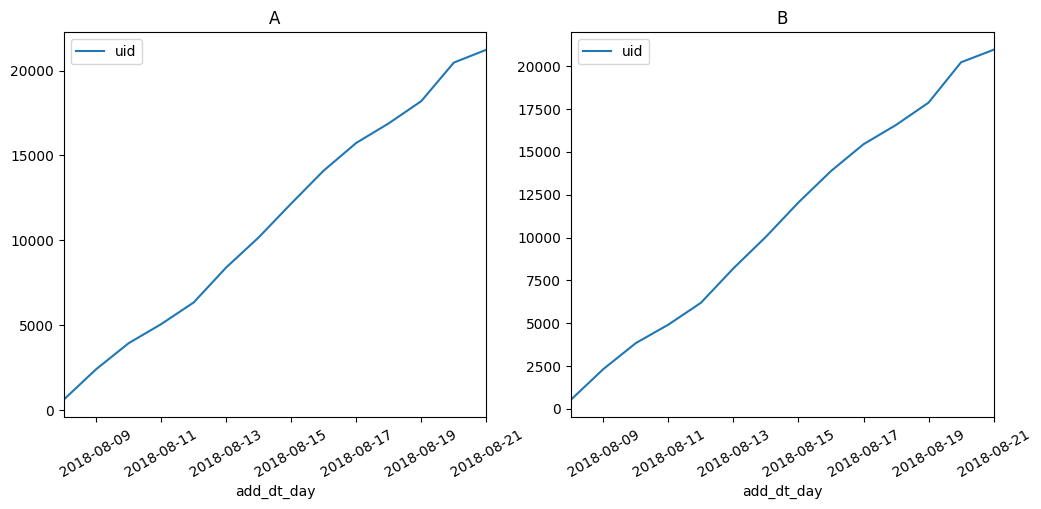

In [254]:
_, ax = plt.subplots(1, 2, figsize = (12,5))
myFmt_major = mdates.DateFormatter('%Y-%m-%d')
myFmt_minor = mdates.DateFormatter('%Y-%m-%d')
myLoc = mdates.DayLocator(interval=2)
ax = ax.flat
for i, (name, group) in enumerate(ab_test_cum.groupby('case_id')[['uid']]):
    group.reset_index(0, drop=True).plot(ax=ax[i])
    ax[i].xaxis.set_major_formatter(myFmt_major)
    ax[i].xaxis.set_minor_formatter(myFmt_minor)
    ax[i].xaxis.set_minor_locator(myLoc)
    ax[i].xaxis.set_major_locator(myLoc)
    ax[i].set(ylabel = None
       , title = name
       , label=None)
    ax[i].tick_params(axis="x", which="both", rotation=30)

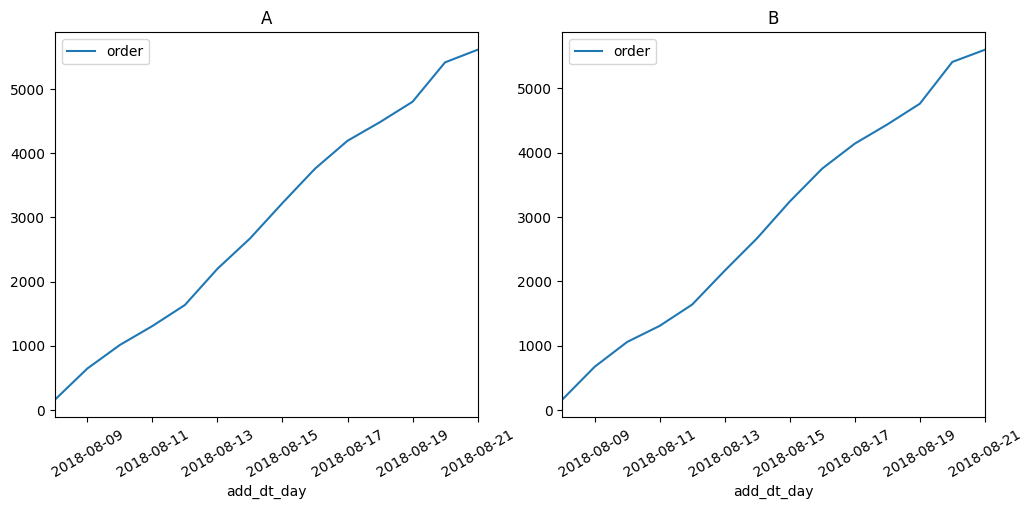

In [255]:
_, ax = plt.subplots(1, 2, figsize = (12,5))
myFmt_major = mdates.DateFormatter('%Y-%m-%d')
myFmt_minor = mdates.DateFormatter('%Y-%m-%d')
myLoc = mdates.DayLocator(interval=2)
ax = ax.flat
for i, (name, group) in enumerate(ab_test_cum.groupby('case_id')[['order']]):
    group.reset_index(0, drop=True).plot(ax=ax[i])
    ax[i].xaxis.set_major_formatter(myFmt_major)
    ax[i].xaxis.set_minor_formatter(myFmt_minor)
    ax[i].xaxis.set_minor_locator(myLoc)
    ax[i].xaxis.set_major_locator(myLoc)
    ax[i].set(ylabel = None
       , title = name
       , label=None)
    ax[i].tick_params(axis="x", which="both", rotation=30)

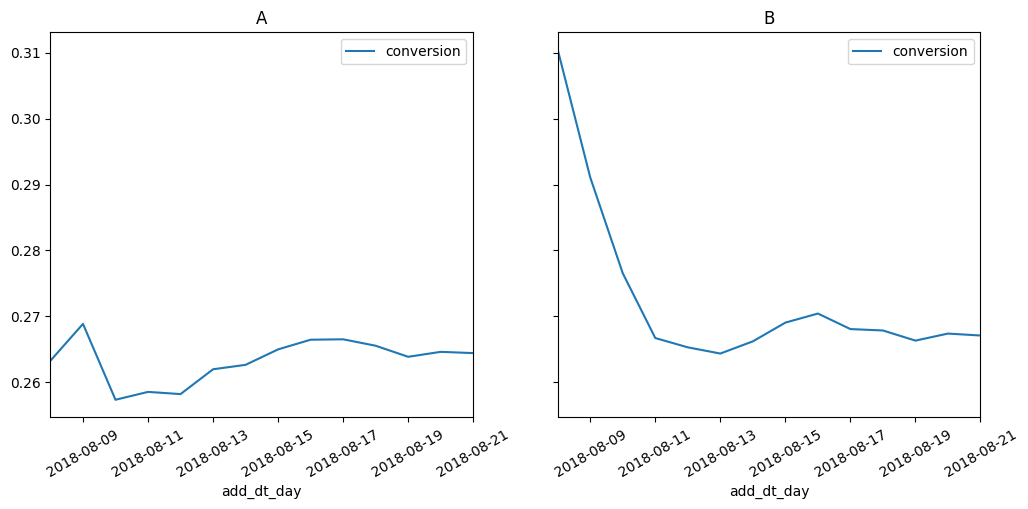

In [256]:
_, ax = plt.subplots(1, 2, figsize = (12,5), sharey=True)
myFmt_major = mdates.DateFormatter('%Y-%m-%d')
myFmt_minor = mdates.DateFormatter('%Y-%m-%d')
myLoc = mdates.DayLocator(interval=2)
ax = ax.flat
for i, (name, group) in enumerate(ab_test_cum.groupby('case_id')[['conversion']]):
    group.reset_index(0, drop=True).plot(ax=ax[i])
    ax[i].xaxis.set_major_formatter(myFmt_major)
    ax[i].xaxis.set_minor_formatter(myFmt_minor)
    ax[i].xaxis.set_minor_locator(myLoc)
    ax[i].xaxis.set_major_locator(myLoc)
    ax[i].set(ylabel = None
       , title = name
       , label=None)
    ax[i].tick_params(axis="x", which="both", rotation=30)

<Axes: xlabel='add_dt_day'>

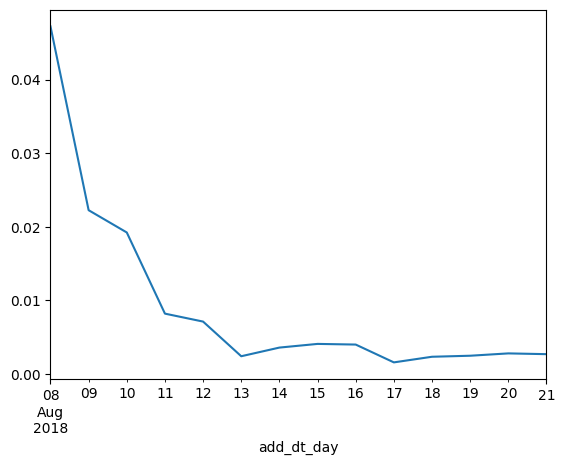

In [257]:
(ab_test_cum.loc['B'].conversion - ab_test_cum.loc['A'].conversion).plot()

In [259]:
ar = []
for i in range(len(ab_test_cum.loc['A'])):
    count = [ab_test_cum.order.loc['A'][i], ab_test_cum.order.loc['B'][i]]
    nobs = [ab_test_cum.loc['A'].uid[i], ab_test_cum.loc['B'].uid[i]]
    stats, pvalue = sapi.proportions_ztest(count, nobs)
    ar.append(pvalue)
ar[:10]

[0.07958325933810372,
 0.08870285905134012,
 0.05546764670130104,
 0.35311535697716867,
 0.36603613309432803,
 0.726621703062595,
 0.5653650574217461,
 0.4744946173796749,
 0.45280093741129857,
 0.7564404854195879]

In [260]:
pvalue = ab_test_cum.loc['A'].reset_index()[['add_dt_day']]
pvalue['p_value'] = ar
pvalue.head()

,add_dt_day,p_value
0,2018-08-08,0.079583
1,2018-08-09,0.088703
2,2018-08-10,0.055468
3,2018-08-11,0.353115
4,2018-08-12,0.366036


<Axes: xlabel='add_dt_day'>

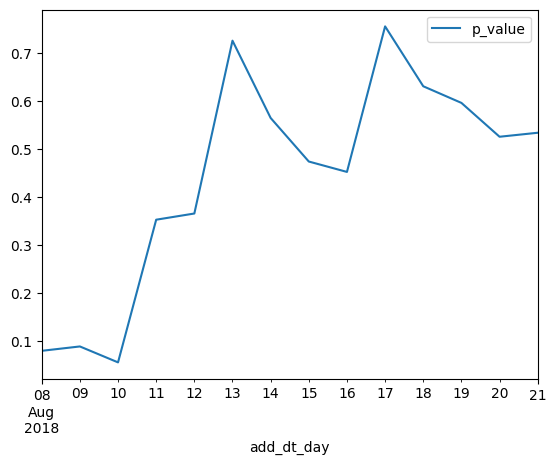

In [261]:
pvalue.set_index('add_dt_day').plot()

In [262]:
ab_test_cum.groupby('case_id').last()

,uid,order,conversion
case_id,,,
A,21226,5612,0.264393
B,20965,5599,0.267064


In [265]:
df.head()

,uid,case_id,received_time,price,pay_status,order_id,add_dt_day,received_day,order
0,d79239f40f08cb4a8293f11e2a322858b1b3cf77b44d4f...,A,NaT,NaN,NaN,NaN,2018-08-20,NaN,NaN
1,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:38:49,3157.0,0.0,14381314.0,2018-08-20,20.0,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...
2,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:40:05,NaN,0.0,NaN,2018-08-20,20.0,NaN
3,c4fd4b441c1c00a6347e12538aa46b9114595c82da04ad...,A,NaT,NaN,NaN,NaN,2018-08-18,NaN,NaN
4,7b4a246f85249487334f60a2e8d0f6d9c33e4635c083b7...,A,NaT,NaN,NaN,NaN,2018-08-10,NaN,NaN


Сравним среднюю цену заказов

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45256 entries, 0 to 45255
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   uid            45256 non-null  object        
 1   case_id        45256 non-null  object        
 2   received_time  16245 non-null  datetime64[ns]
 3   price          13990 non-null  float64       
 4   pay_status     16245 non-null  float64       
 5   order_id       11211 non-null  float64       
 6   add_dt_day     45256 non-null  datetime64[ns]
 7   received_day   16245 non-null  float64       
 8   order          11211 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 3.1+ MB


In [287]:
df.groupby(['case_id', 'order']).agg(order_price=('price', 'sum')).groupby('case_id').agg(avg_price=('order_price', 'mean'))

,avg_price
case_id,
A,2612.550606
B,1908.439721


<Axes: >

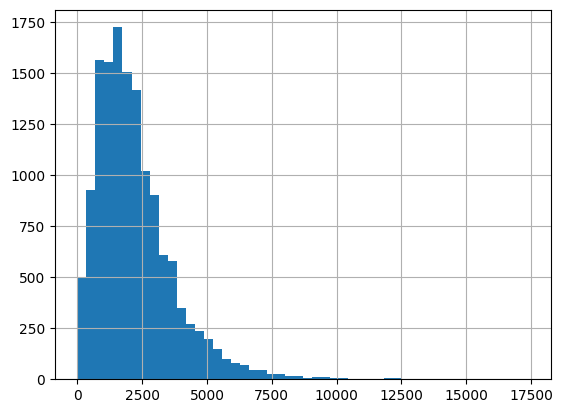

In [286]:
df.price.hist(bins=50)

In [289]:
df_price = df.groupby(['case_id', 'order']).agg(order_price=('price', 'sum'))
df_price

order_price
case_id order                                                          
A       00040c8afbb8b4764104b3d16da427ff295f8f89d578122...       1101.0
        00049d7415fa8a552201ed220244efaa6ddf1aeb940847a...       1870.0
        000e9b7fd47c051e59a75a8fdab33b398d3369c6fc5021c...       1744.0
        00265c63bd8a04dd89492a6870bb313967384acc96b6339...       2546.0
        003c192acc367e26a4943c57f59f686ecbf9e017ff23ec7...       1311.0
...                                                                 ...
B       ffcf53f182adfe0ddc9139359393d101b4202bb0b457a3a...       6400.0
        ffd91327a96789d8ce71663ebc14a025838e453389def23...       8400.0
        fff1dd4cdc948864189c4754e39a9fc512c3ae4af241d18...        850.0
        fff2e0cc160d8874c89ec6c4650c49e0c036688fc302702...        800.0
        fff2e0cc160d8874c89ec6c4650c49e0c036688fc302702...        700.0

[11211 rows x 1 columns]

In [291]:
df_price.loc['A'].order_price

order
00040c8afbb8b4764104b3d16da427ff295f8f89d578122ceaaf41a6 14311088.0    1101.0
00049d7415fa8a552201ed220244efaa6ddf1aeb940847a0ad6d8005 14290065.0    1870.0
000e9b7fd47c051e59a75a8fdab33b398d3369c6fc5021c8f9ca6812 14264483.0    1744.0
00265c63bd8a04dd89492a6870bb313967384acc96b6339ebc25dd21 14305847.0    2546.0
003c192acc367e26a4943c57f59f686ecbf9e017ff23ec79367d6640 14259221.0    1311.0
                                                                        ...  
ffca4d6209023231acf7028e397884e4cde8d6b2fdb7ac08fdaa1791 14256046.0    2384.0
ffd52ef88888607d58c6ed2374241487f0586561481336a1e80f1c94 14334509.0    4334.0
ffdd3787af8d935ba540dafd7c68167c6163d390adc1070d4cf81949 14351415.0    1885.0
fff08b27d1fbd8944c2c0219eb2fc7f8391c60e8f0f5b047a022af4a 14312448.0    1866.0
fffcac8f566a49836cc9ad9415f1cba6abf3f114a88bd4c08660538c 14373648.0    4793.0
Name: order_price, Length: 5612, dtype: float64

In [292]:
price_a = df_price.loc['A'].order_price
price_b = df_price.loc['B'].order_price

In [293]:
st.ttest_ind(price_a, price_b)

TtestResult(statistic=25.302387724925463, pvalue=2.066717777499449e-137, df=11209.0)

In [295]:
st.mannwhitneyu(price_a, price_b)

MannwhitneyuResult(statistic=21381345.5, pvalue=3.426890862017267e-240)

<Axes: xlabel='order_price', ylabel='Count'>

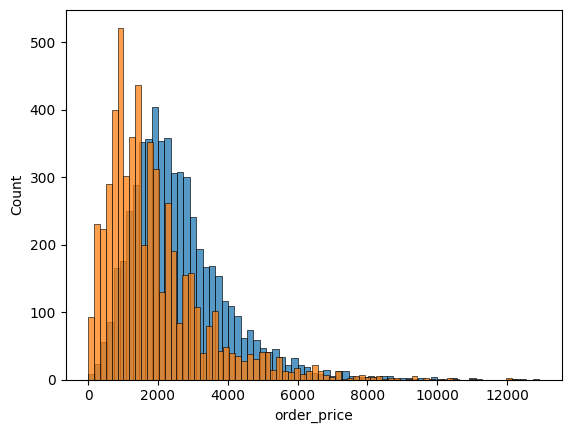

In [299]:
ax = sns.histplot(price_a)
sns.histplot(price_b, ax=ax)

ConfidenceInterval(low=2575.258597647897, high=2650.2627405559515)


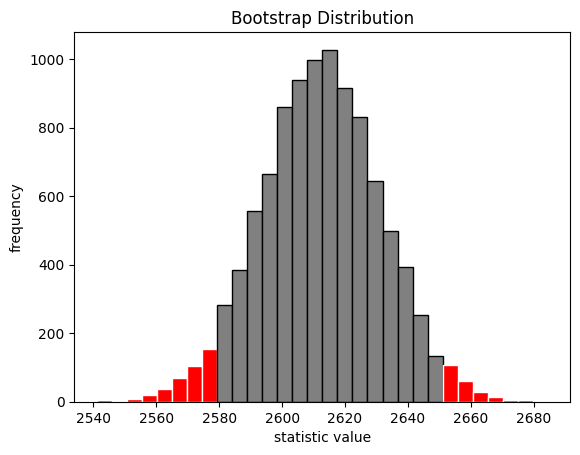

In [309]:
data = (price_a, )
res_a = st.bootstrap(data, np.mean, method='basic', random_state=1)
print(res_a.confidence_interval)
fig, ax = plt.subplots()
_, _, bars = ax.hist(res_a.bootstrap_distribution, bins=30, ec='w')
for bar in bars:
    if bar.get_x() < res_a.confidence_interval[0] or bar.get_x() > res_a.confidence_interval[1]:
        bar.set_facecolor('red')
    else:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

ConfidenceInterval(low=1868.5486515449188, high=1948.070923379175)


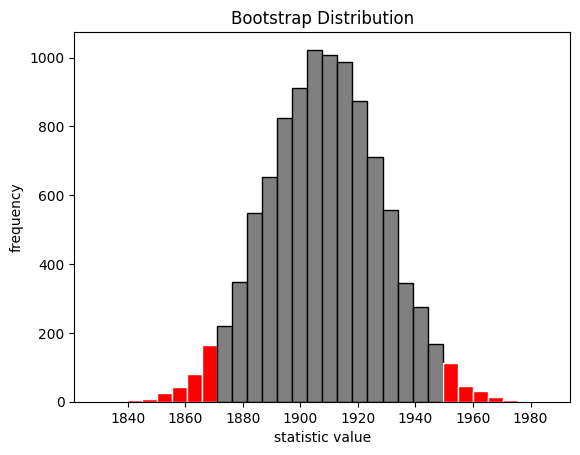

In [308]:
data = (price_b, )
res_b = st.bootstrap(data, np.mean, method='basic', random_state=1)
print(res_b.confidence_interval)
fig, ax = plt.subplots()
_, _, bars = ax.hist(res_b.bootstrap_distribution, bins=30, ec='w')
for bar in bars:
    if bar.get_x() < res_b.confidence_interval[0] or bar.get_x() > res_b.confidence_interval[1]:
        bar.set_facecolor('red')
    else:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

<Axes: ylabel='Count'>

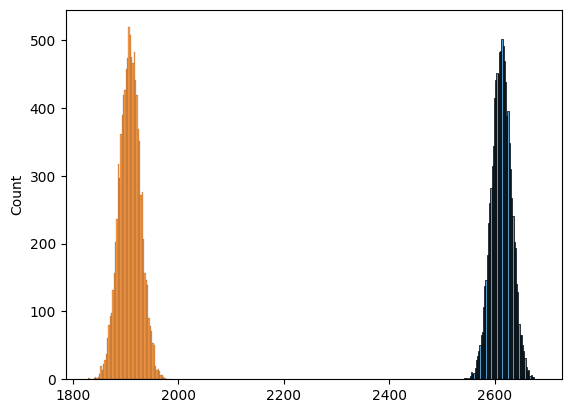

In [310]:
ax = sns.histplot(res_a.bootstrap_distribution)
sns.histplot(res_b.bootstrap_distribution, ax=ax)

<Axes: ylabel='Count'>

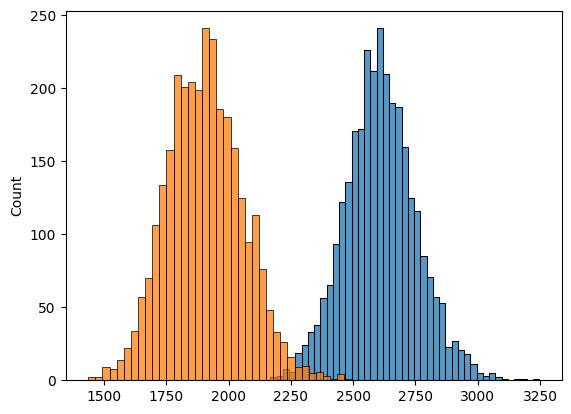

In [311]:
def bootstrap(arr,n=100,N_TRIAL = 1000,func = np.mean):
    res = []
    n = min(len(arr),n)
    # Инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # Делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size = (n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size = (n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res # shape (N_TRIAL,)
samples_a = bootstrap(price_a,N_TRIAL = 3000)
samples_b = bootstrap(price_b,N_TRIAL = 3000)
ax = sns.histplot(samples_a)
sns.histplot(samples_b, ax=ax)

ConfidenceInterval(low=-759.3813240120132, high=-649.2656296460887)


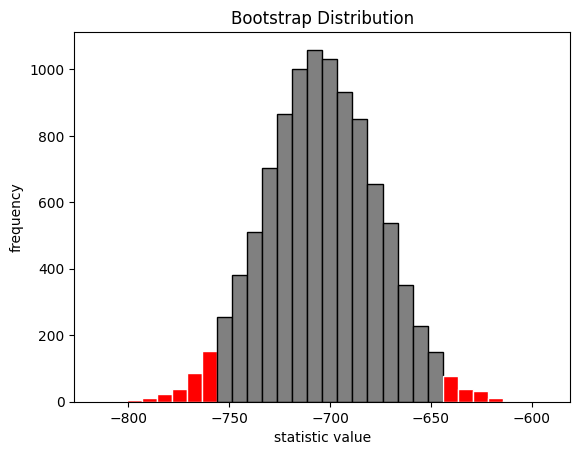

In [297]:
def my_statistic(sample1, sample2, axis=-1):
     return np.mean(sample1, axis=-1) - np.mean(sample2, axis=-1)
data = (price_b.to_numpy(), price_a.to_numpy())
res = st.bootstrap(data, my_statistic, method='basic', random_state=1)
print(res.confidence_interval)
fig, ax = plt.subplots()
_, _, bars = ax.hist(res.bootstrap_distribution, bins=30, ec='w')
for bar in bars:
    if bar.get_x() < res.confidence_interval[0] or bar.get_x() > res.confidence_interval[1]:
        bar.set_facecolor('red')
    else:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()